In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import uuid

In [2]:
# Convert RGB to grayscale for individual images using PIL/Pillow only
def convert_to_grayscale(input_folder, output_folder):
    for class_folder in os.listdir(input_folder):
        class_folder_path = os.path.join(input_folder, class_folder)
        output_class_folder_path = os.path.join(output_folder, class_folder)
        os.makedirs(output_class_folder_path, exist_ok=True)

        for image_file in os.listdir(class_folder_path):
            image_path = os.path.join(class_folder_path, image_file)
            image = Image.open(image_path)

            grayscale_image = image.convert("L")

            output_path = os.path.join(output_class_folder_path, f"{uuid.uuid4().hex}.jpg")
            grayscale_image.save(output_path)

            print(f"Converted {image_file} to grayscale and saved as {output_path}")

In [3]:
# Load grayscale images and labels
def load_images(folder_path):
    images = []
    labels = []

    for class_folder in os.listdir(folder_path):
        class_folder_path = os.path.join(folder_path, class_folder)

        if os.path.isdir(class_folder_path):
            for image_file in os.listdir(class_folder_path):
                image_path = os.path.join(class_folder_path, image_file)

                image = Image.open(image_path)
                image_array = np.array(image)
                flattened_image = image_array.flatten()

                images.append(flattened_image)
                labels.append(class_folder)

    return np.array(images), np.array(labels)

In [4]:
# Perform 5-fold cross-validation and train KNN classifiers
def perform_kfold_cross_validation(images, labels, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold = 1
    accuracies_manhattan = []
    accuracies_euclidean = []

    for train_index, test_index in kf.split(images):
        print(f"Fold: {fold}")
        train_images, test_images = images[train_index], images[test_index]
        train_labels, test_labels = labels[train_index], labels[test_index]

        knn_manhattan = KNeighborsClassifier(n_neighbors=5, metric='manhattan')
        knn_euclidean = KNeighborsClassifier(n_neighbors=5, metric='euclidean')

        knn_manhattan.fit(train_images, train_labels)
        knn_euclidean.fit(train_images, train_labels)

        predictions_manhattan = knn_manhattan.predict(test_images)
        predictions_euclidean = knn_euclidean.predict(test_images)

        accuracy_manhattan = accuracy_score(test_labels, predictions_manhattan)
        accuracy_euclidean = accuracy_score(test_labels, predictions_euclidean)

        accuracies_manhattan.append(accuracy_manhattan)
        accuracies_euclidean.append(accuracy_euclidean)

        print("Accuracy (Manhattan):", accuracy_manhattan)
        print("Accuracy (Euclidean):", accuracy_euclidean)
        print("------------------")
        fold += 1

    return accuracies_manhattan, accuracies_euclidean

In [5]:
# Load test images and labels
def load_test_images(folder_path):
    images = []
    labels = []

    for image_file in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_file)

        image = Image.open(image_path)
        image_array = np.array(image)
        flattened_image = image_array.flatten()

        images.append(flattened_image)
        labels.append(image_file.split("_")[0])  # Extract the class label from the file name

    if len(images) == 0 or len(labels) == 0:
        raise ValueError("Test images not found or empty.")

    return np.array(images), np.array(labels)


In [ ]:
# Paths for input and output folders
input_folder = r"C:\Users\Asus\Desktop\cvpr\CIFAR-10-images-master\train"
output_folder = r"C:\Users\Asus\Desktop\cvpr\CIFAR-10-images-master\Grayscale"

# Convert RGB to grayscale for both train and test images
convert_to_grayscale(input_folder, os.path.join(output_folder, "G_train"))


In [7]:
# Load grayscale images and labels for training
train_folder = os.path.join(output_folder, "G_train")
train_images, train_labels = load_images(train_folder)

Fold: 1
Accuracy (Manhattan): 0.3054
Accuracy (Euclidean): 0.2795
------------------
Fold: 2
Accuracy (Manhattan): 0.306
Accuracy (Euclidean): 0.2812
------------------
Fold: 3
Accuracy (Manhattan): 0.3009
Accuracy (Euclidean): 0.2781
------------------
Fold: 4
Accuracy (Manhattan): 0.2965
Accuracy (Euclidean): 0.2773
------------------
Fold: 5
Accuracy (Manhattan): 0.3071
Accuracy (Euclidean): 0.2833
------------------


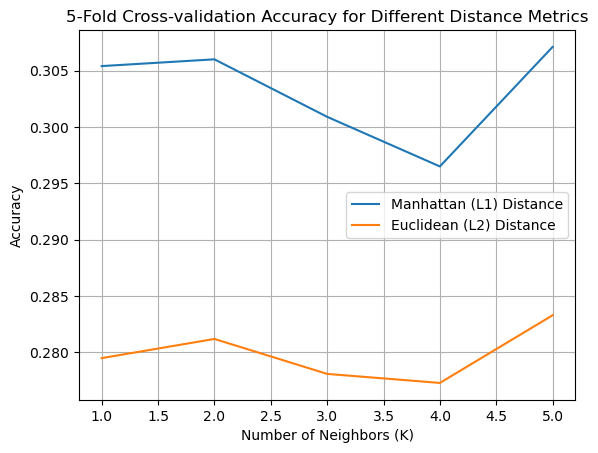

In [8]:
# Perform 5-fold cross-validation and getting accuracy scores for Manhattan and Euclidean distances
n_splits = min(5, len(train_images))  
manhattan_accuracies, euclidean_accuracies = perform_kfold_cross_validation(train_images, train_labels, n_splits=n_splits)

# Plotting the cross-validation accuracy for L1 and L2 distance metrics
k_values = range(1, n_splits + 1)  # Use n_splits instead of 11
plt.plot(k_values, manhattan_accuracies, label='Manhattan (L1) Distance')
plt.plot(k_values, euclidean_accuracies, label='Euclidean (L2) Distance')
plt.title(f'{n_splits}-Fold Cross-validation Accuracy for Different Distance Metrics')  
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [9]:
# Save the training dataset to KNN_train folder in the specified path
knn_train_path = os.path.join(output_folder, "KNN_train")
os.makedirs(knn_train_path, exist_ok=True)

for image, label in zip(train_images, train_labels):
    class_folder_path = os.path.join(knn_train_path, label)
    os.makedirs(class_folder_path, exist_ok=True)
    image_path = os.path.join(class_folder_path, f"train_image_{uuid.uuid4().hex}.jpg")
    image_array = image.reshape((32, 32))
    image_gray = Image.fromarray(image_array.astype(np.uint8), mode='L')
    image_gray.save(image_path)


In [10]:
# Load test images and labels for evaluation (from test folder)
def load_test_images(folder_path):
    images = []
    labels = []

    for class_folder in os.listdir(folder_path):
        class_folder_path = os.path.join(folder_path, class_folder)

        if os.path.isdir(class_folder_path):
            for image_file in os.listdir(class_folder_path):
                image_path = os.path.join(class_folder_path, image_file)

                image = Image.open(image_path)
                image_array = np.array(image)
                flattened_image = image_array.flatten()

                images.append(flattened_image)
                labels.append(class_folder)

    if len(images) == 0 or len(labels) == 0:
        raise ValueError("Test images not found or empty.")

    return np.array(images), np.array(labels)

test_folder = r"C:\Users\Asus\Desktop\cvpr\CIFAR-10-images-master\test"
test_images, test_labels = load_test_images(test_folder)


In [11]:
# Create KNN classifiers for Manhattan and Euclidean distances
knn_manhattan = KNeighborsClassifier(n_neighbors=5, metric='manhattan')
knn_euclidean = KNeighborsClassifier(n_neighbors=5, metric='euclidean')

In [12]:
# Load and train the KNN classifiers with the training data
knn_train_images, knn_train_labels = load_images(knn_train_path)
knn_manhattan.fit(knn_train_images, knn_train_labels)
knn_euclidean.fit(knn_train_images, knn_train_labels)

KNeighborsClassifier(metric='euclidean')

In [13]:
# Make predictions on the test images using both classifiers
predictions_manhattan = knn_manhattan.predict(test_images)
predictions_euclidean = knn_euclidean.predict(test_images)

In [17]:
# Organize the predictions by class
class_predictions_manhattan = {label: [] for label in np.unique(test_labels)}
class_predictions_euclidean = {label: [] for label in np.unique(test_labels)}

for i in range(len(test_images)):
    true_label = test_labels[i]
    class_predictions_manhattan[true_label].append(predictions_manhattan[i])
    class_predictions_euclidean[true_label].append(predictions_euclidean[i])

In [18]:
# Display top 5 predictions for each class
for label in np.unique(test_labels):
    top_predictions_manhattan = np.array(class_predictions_manhattan[label])
    top_predictions_euclidean = np.array(class_predictions_euclidean[label])

    print("Class:", label)
    print("Top 5 Predicted Labels (Manhattan):", np.unique(top_predictions_manhattan)[:5])
    print("Top 5 Predicted Labels (Euclidean):", np.unique(top_predictions_euclidean)[:5])
    print("--------------------")

Class: airplane
Top 5 Predicted Labels (Manhattan): ['airplane' 'automobile' 'bird' 'cat' 'deer']
Top 5 Predicted Labels (Euclidean): ['airplane' 'automobile' 'bird' 'cat' 'deer']
--------------------
Class: automobile
Top 5 Predicted Labels (Manhattan): ['airplane' 'automobile' 'bird' 'cat' 'deer']
Top 5 Predicted Labels (Euclidean): ['airplane' 'automobile' 'bird' 'cat' 'deer']
--------------------
Class: bird
Top 5 Predicted Labels (Manhattan): ['airplane' 'automobile' 'bird' 'cat' 'deer']
Top 5 Predicted Labels (Euclidean): ['airplane' 'automobile' 'bird' 'cat' 'deer']
--------------------
Class: cat
Top 5 Predicted Labels (Manhattan): ['airplane' 'automobile' 'bird' 'cat' 'deer']
Top 5 Predicted Labels (Euclidean): ['airplane' 'automobile' 'bird' 'cat' 'deer']
--------------------
Class: deer
Top 5 Predicted Labels (Manhattan): ['airplane' 'automobile' 'bird' 'cat' 'deer']
Top 5 Predicted Labels (Euclidean): ['airplane' 'automobile' 'bird' 'cat' 'deer']
--------------------
Class:

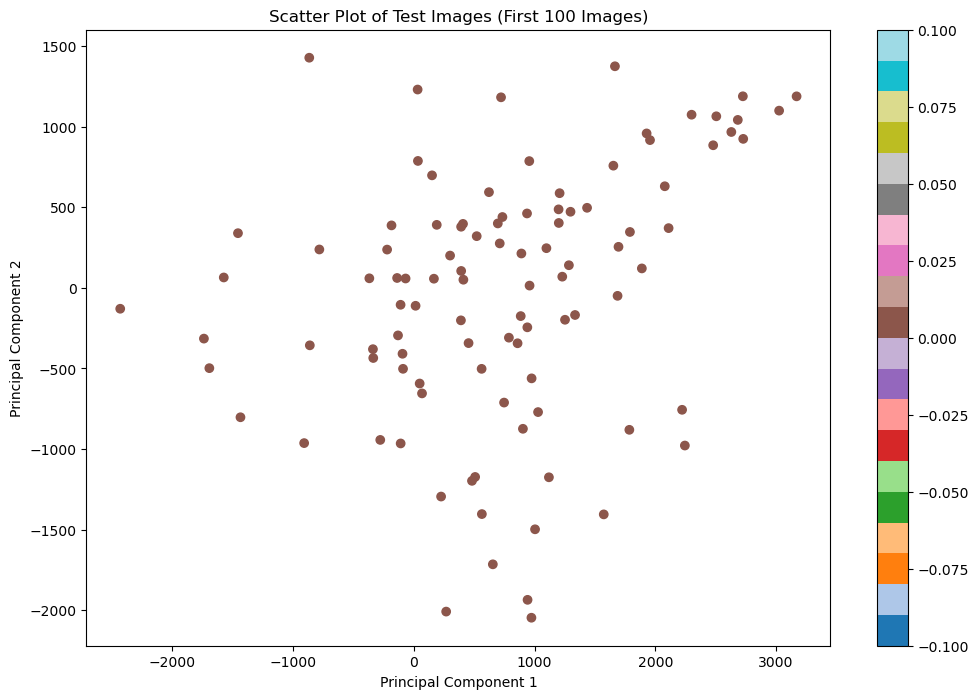

In [16]:
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
test_images_2d = pca.fit_transform(test_images)

label_encoder = LabelEncoder()
test_labels_encoded = label_encoder.fit_transform(test_labels)

# Create scatter plot for the first 100 test images
plt.figure(figsize=(12, 8))
plt.scatter(test_images_2d[:100, 0], test_images_2d[:100, 1], c=test_labels_encoded[:100], cmap=plt.cm.tab20, marker='o')
plt.title('Scatter Plot of Test Images (First 100 Images)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()
